# 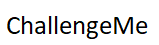
### The objective of this set of data is to create a challenge metrics between clubs, individuals or teams. Depending on speed, distance, altitude.
# Strava API research
### The objective of this area is to review the strava extraction.

##### In order to  obtain each athlete activities its required by the strava api to obtain authorization of each athlete. Authorization is requested by building the following url  https://www.strava.com/oauth/authorize?client_id=your_client_id&redirect_uri=http://localhost&response_type=code&scope=activity:read_all this is a only one step per athlete added to your app. This needs to be automated using a web pipeline that will grab each athletes authorizations and save it in a database. When athletes grant us access we obtain an access token in the response url that looks like this. http://localhost/?state=&code=[code we require]&scope=read,activity:read_all. This process was done manually for automation it requires  to have a web server setup that Strava can post back to after athlete "Authorize".
##### Next step is to exchange authorization code for an access token and refresher. access token expires and refresher token don't. You need to use refresher token to obtain a new access token.

## Import libraries

In [2]:
import requests
import urllib3
import json
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from pandas.io.json import json_normalize  


urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Support functions 

In [4]:
##Read JSON file
def read_json(file):
    # read file
    with open(file, 'r') as myfile:
        data=myfile.read()
    # parse file
    obj = json.loads(data)
    return obj

##Save JSON file
def savefile(name,data):
    with open(name, 'w') as json_file:
        json.dump(data, json_file)

## Exchanging authorization code(only one time process)

In [128]:

def authorization_code_exchange(clientfile,codeAuthAthlete):
    #Request URL
    oauth_url='https://www.strava.com/oauth/token'
    client_data=read_json(clientfile)
    #Payload
    payload = {
        'client_id': client_data['client_id'],
        'client_secret': client_data['client_secret'],
        'code': codeAuthAthlete,
        'grant_type': "authorization_code",
        'f': 'json'
    }
    header = {'Authorization': 'Bearer ' + client_data['access_token']['token']}
    param = {'per_page': 200, 'page': 1}
    #Posting Request
    res = requests.post(auth_url, data=payload, headers=header,verify=False)
    return res.json()
#data=authorization_code_exchange("./client_data/client.json",'XXXXXXXXXXXXX')
#savefile('123.json',data)

### Requesting new authorization token when it expires using refresh token 

In [130]:
def authorization_code_refresh(clientfile,athletefile):
    #Making request URL
    auth_url = "https://www.strava.com/oauth/token"
    client_data=read_json(clientfile)
    athlete_data=read_json(athletefile)
    
    #Payload
    payload= {
        'client_id': client_data['client_id'],
        'client_secret': client_data['client_secret'],
        'refresh_token': athlete_data['refresh_token'],
        'grant_type': "refresh_token",
        'f': 'json'
    }
    #Need to refresh token
    print("Requesting Token...\n")
    #Posting Request
    res = requests.post(auth_url, data=payload, verify=False)
    #Pulling access token
    access_token = res.json()['access_token']
    return access_token
access_token=authorization_code_refresh('./client_data/client.json','./athlete_token/18764561.json')
access_token

Requesting Token...



'db527fa723bb6e87968305e6b7ac2dc0e43c2608'

### Request athlete activities

In [133]:
def athlete_activities(athlete_token):
    activites_url = "https://www.strava.com/api/v3/athlete/activities"
    header = {'Authorization': 'Bearer ' + athlete_token}
    param = {'per_page': 200, 'page': 1}
    my_dataset = requests.get(activites_url, headers=header, params=param).json()
    return my_dataset

my_dataset=athlete_activities(access_token)
#print(len(my_dataset))
#savefile('strava_adame_activities',my_dataset)

46


### Request club name

In [132]:
#Getting clubs name

def athlete_clubs(athlete_token):
    clubs_url = "https://www.strava.com/api/v3/athlete/clubs"
    #Header
    header = {'Authorization': 'Bearer ' + athlete_token}
    #params
    params = {
    'page': "1",
    'per_page': '30',
    }
    my_clubs = requests.get(clubs_url, headers=header, params=param).json()
    return my_clubs
#savefile('strava_adame_clubs',athlete_clubs(access_token))

## Cleaning Area

#### Load obtained data in one data set to clean

In [5]:
#Data to dataframe
def data_to_dataframe(obj):
    data_list=[]
    for i in range(len(obj)):
        data_list.append(obj[i])
    df = pd.DataFrame(data_list)
    return df
#file info append to data frame
def extract_info(activitiespath):
    files = [f for f in listdir(activitiespath) if isfile(join(activitiespath,f))]
    #concatenate data 
    dafa=pd.DataFrame()
    for elem in files:
        actividades=read_json(activitiespath+elem)
        data=data_to_dataframe(actividades)
        dafa=dafa.append(data)
    return dafa
    #return data_to_dataframe(obj)

dataframe_activities=extract_info('./athlete_activities/')


   

#### Clean nulls

In [6]:
#Review nulls in columns
df_clean=dataframe_activities.copy()
def clean_nulls(df_cleaning):
    null_cols = df_cleaning.isnull().sum()
    print(null_cols[null_cols > 0])
    #Drop columns that only have nulls
    drop_cols = list(null_cols[null_cols > 189].index)
    df_cleaning = df_cleaning.drop(drop_cols, axis=1)
    return df_cleaning
#Clean nulls
df_without_nulls=clean_nulls(df_clean)
len(df_clean)
null_cols = df_without_nulls.isnull().sum()
print(null_cols[null_cols > 0])

workout_type              106
external_id                17
start_latlng               58
end_latlng                 58
location_city             192
location_state            192
location_country          192
start_latitude             58
start_longitude            58
gear_id                   192
device_watts               63
elev_high                  19
elev_low                   19
average_temp               99
average_heartrate          98
max_heartrate              98
average_cadence           168
average_watts             190
weighted_average_watts    190
kilojoules                190
max_watts                 190
dtype: int64
workout_type         106
external_id           17
start_latlng          58
end_latlng            58
start_latitude        58
start_longitude       58
device_watts          63
elev_high             19
elev_low              19
average_temp          99
average_heartrate     98
max_heartrate         98
average_cadence      168
dtype: int64


In [7]:
#Replace nan with -1
def fill_na(df_lean):
    null_cols = df_lean.isnull().sum()
    list_null=list(null_cols[null_cols > 0].keys())
    print(list_null)
    df_lean[list_null] = df_lean[list_null].fillna(-1)
    return df_lean
df_fill_na=fill_na(df_without_nulls)

['workout_type', 'external_id', 'start_latlng', 'end_latlng', 'start_latitude', 'start_longitude', 'device_watts', 'elev_high', 'elev_low', 'average_temp', 'average_heartrate', 'max_heartrate', 'average_cadence']


In [8]:
#Delete fields that do not give relevant information
def review_variance(d_lean):
    low_variance = []
    for col in d_lean._get_numeric_data():
        minimum = min(d_lean[col])
        ninety_perc = np.percentile(d_lean[col], 90)
        if ninety_perc == minimum:
            low_variance.append(col)
    print(low_variance)
    d_lean = d_lean.drop(low_variance,axis=1)
    return d_lean
df_variance=review_variance(df_fill_na)

['resource_state', 'comment_count', 'photo_count', 'commute', 'manual', 'private', 'flagged', 'from_accepted_tag', 'heartrate_opt_out', 'has_kudoed']


In [9]:
#outlayer

def outlayer(dataframes):
    stats = dataframes.describe().transpose()
    stats['IQR'] = stats['75%'] - stats['25%']
    stats

    outliers = pd.DataFrame(columns=dataframes.columns)
    for col in stats.index:
        iqr = stats.at[col,'IQR']
        cutoff = iqr * 1.5
        lower = stats.at[col,'25%'] - cutoff
        upper = stats.at[col,'75%'] + cutoff
        results = dataframes[(dataframes[col] < lower) | 
                   (dataframes[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)
    return outliers
#Review outliers
out=outlayer(df_variance)
#start reviewing
out.drop(index=out[out['Outlier'] == 'average_cadence'].index, inplace=True)
#Need to review each one this an help to find fault data like recording cycling activity while you go into your pcar
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(out.head(1))
len(out)
#No important outliers found to drop

,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,external_id,upload_id,start_date,start_date_local,timezone,utc_offset,start_latlng,end_latlng,start_latitude,start_longitude,achievement_count,kudos_count,athlete_count,map,trainer,visibility,upload_id_str,average_speed,max_speed,device_watts,has_heartrate,display_hide_heartrate_option,elev_high,elev_low,pr_count,total_photo_count,average_temp,average_heartrate,max_heartrate,average_cadence,Outlier


0

In [11]:
#Flatten columns
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_variance.head(5))
def flatten_athlete(df_var):
    #Flatten athlete column
    df_frame=pd.DataFrame()
    #pd.merge(left, right, on='key')
    df_frame=df_var.copy()
    athlete=pd.json_normalize(df_var['athlete'])
    df_frame['athlete_id']=athlete['id']
    df_frame=df_frame.drop('athlete',axis=1)
    return df_frame

df_flat=flatten_athlete(df_variance)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_flat.head(5))


,athlete,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,external_id,upload_id,start_date,start_date_local,timezone,utc_offset,start_latlng,end_latlng,start_latitude,start_longitude,achievement_count,kudos_count,athlete_count,map,trainer,visibility,upload_id_str,average_speed,max_speed,device_watts,has_heartrate,display_hide_heartrate_option,elev_high,elev_low,pr_count,total_photo_count,average_temp,average_heartrate,max_heartrate,average_cadence
0,"{'id': 18764561, 'resource_state': 1}",Vuelta ciclista por la mañana,17468.9,4418,5690,43.1,Ride,-1.0,2419159884,06E2E387-1EC5-4ECB-B4F3-861224CF7A9E,2571663455,2019-06-01T15:14:25Z,2019-06-01T10:14:25Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.668804, -100.273421]","[20.668783, -100.273552]",20.668804,-100.273421,0,0,3,"{'id': 'a2419159884', 'summary_polyline': '_{c...",False,everyone,2571663455,3.954,8.2,False,False,False,1915.0,1888.6,0,0,-1.0,-1.0,-1.0,-1.0
1,"{'id': 18764561, 'resource_state': 1}",Vuelta ciclística por la mañana,78393.7,11382,13243,440.5,Ride,10.0,2399952243,c1091c6ca82ec0d528d5b6d43c55fbeb,2551761952,2019-05-26T16:04:24Z,2019-05-26T11:04:24Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.618814, -100.452507]","[20.618389, -100.452366]",20.618814,-100.452507,3,2,1,"{'id': 'a2399952243', 'summary_polyline': 'qbz...",False,everyone,2551761952,6.888,18.8,False,False,False,2040.6,1802.1,0,0,-1.0,-1.0,-1.0,-1.0
2,"{'id': 18764561, 'resource_state': 1}",Vuelta ciclística por la mañana,87375.2,12534,14293,469.1,Ride,10.0,2378117887,203e4367b333b474a9c560465bd3e663,2529208748,2019-05-18T14:51:43Z,2019-05-18T09:51:43Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.617179, -100.450575]","[20.618613, -100.452233]",20.617179,-100.450575,7,4,1,"{'id': 'a2378117887', 'summary_polyline': 'ixy...",False,everyone,2529208748,6.971,21.4,False,False,False,2040.6,1802.1,3,0,-1.0,-1.0,-1.0,-1.0
3,"{'id': 18764561, 'resource_state': 1}",Vuelta ciclística por la tarde,12171.1,2607,3887,54.5,Ride,10.0,2365354281,c1cfcb0c466775f19f6252979b84bcee,2516046859,2019-05-13T20:54:33Z,2019-05-13T15:54:33Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.619541, -100.382021]","[20.618474, -100.452411]",20.619541,-100.382021,3,2,1,"{'id': 'a2365354281', 'summary_polyline': 'cgz...",False,everyone,2516046859,4.669,14.6,False,False,False,1955.2,1802.1,0,0,-1.0,-1.0,-1.0,-1.0
4,"{'id': 18764561, 'resource_state': 1}",Vuelta ciclística por la mañana,10267.8,2132,4576,142.4,Ride,10.0,2364338211,40bd44c3f098491f2dae9fb7a9f0d1c8,2515003246,2019-05-13T14:05:12Z,2019-05-13T09:05:12Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.616912, -100.448752]","[20.618701, -100.381428]",20.616912,-100.448752,3,2,1,"{'id': 'a2364338211', 'summary_polyline': 'uvy...",False,everyone,2515003246,4.816,11.4,False,False,False,1944.4,1802.1,1,0,-1.0,-1.0,-1.0,-1.0


,name,distance,moving_time,elapsed_time,total_elevation_gain,type,workout_type,id,external_id,upload_id,start_date,start_date_local,timezone,utc_offset,start_latlng,end_latlng,start_latitude,start_longitude,achievement_count,kudos_count,athlete_count,map,trainer,visibility,upload_id_str,average_speed,max_speed,device_watts,has_heartrate,display_hide_heartrate_option,elev_high,elev_low,pr_count,total_photo_count,average_temp,average_heartrate,max_heartrate,average_cadence,athlete_id
0,Vuelta ciclista por la mañana,17468.9,4418,5690,43.1,Ride,-1.0,2419159884,06E2E387-1EC5-4ECB-B4F3-861224CF7A9E,2571663455,2019-06-01T15:14:25Z,2019-06-01T10:14:25Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.668804, -100.273421]","[20.668783, -100.273552]",20.668804,-100.273421,0,0,3,"{'id': 'a2419159884', 'summary_polyline': '_{c...",False,everyone,2571663455,3.954,8.2,False,False,False,1915.0,1888.6,0,0,-1.0,-1.0,-1.0,-1.0,18764561
1,Vuelta ciclística por la mañana,78393.7,11382,13243,440.5,Ride,10.0,2399952243,c1091c6ca82ec0d528d5b6d43c55fbeb,2551761952,2019-05-26T16:04:24Z,2019-05-26T11:04:24Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.618814, -100.452507]","[20.618389, -100.452366]",20.618814,-100.452507,3,2,1,"{'id': 'a2399952243', 'summary_polyline': 'qbz...",False,everyone,2551761952,6.888,18.8,False,False,False,2040.6,1802.1,0,0,-1.0,-1.0,-1.0,-1.0,18764561
2,Vuelta ciclística por la mañana,87375.2,12534,14293,469.1,Ride,10.0,2378117887,203e4367b333b474a9c560465bd3e663,2529208748,2019-05-18T14:51:43Z,2019-05-18T09:51:43Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.617179, -100.450575]","[20.618613, -100.452233]",20.617179,-100.450575,7,4,1,"{'id': 'a2378117887', 'summary_polyline': 'ixy...",False,everyone,2529208748,6.971,21.4,False,False,False,2040.6,1802.1,3,0,-1.0,-1.0,-1.0,-1.0,18764561
3,Vuelta ciclística por la tarde,12171.1,2607,3887,54.5,Ride,10.0,2365354281,c1cfcb0c466775f19f6252979b84bcee,2516046859,2019-05-13T20:54:33Z,2019-05-13T15:54:33Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.619541, -100.382021]","[20.618474, -100.452411]",20.619541,-100.382021,3,2,1,"{'id': 'a2365354281', 'summary_polyline': 'cgz...",False,everyone,2516046859,4.669,14.6,False,False,False,1955.2,1802.1,0,0,-1.0,-1.0,-1.0,-1.0,18764561
4,Vuelta ciclística por la mañana,10267.8,2132,4576,142.4,Ride,10.0,2364338211,40bd44c3f098491f2dae9fb7a9f0d1c8,2515003246,2019-05-13T14:05:12Z,2019-05-13T09:05:12Z,(GMT-06:00) America/Mexico_City,-18000.0,"[20.616912, -100.448752]","[20.618701, -100.381428]",20.616912,-100.448752,3,2,1,"{'id': 'a2364338211', 'summary_polyline': 'uvy...",False,everyone,2515003246,4.816,11.4,False,False,False,1944.4,1802.1,1,0,-1.0,-1.0,-1.0,-1.0,18764561


In [12]:
columns_reorder=['athlete_id','name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'workout_type', 'id', 'external_id',
       'upload_id', 'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'start_latlng', 'end_latlng', 'start_latitude', 'start_longitude',
       'achievement_count', 'kudos_count', 'athlete_count', 'map', 'trainer',
       'visibility', 'upload_id_str', 'average_speed', 'max_speed',
       'device_watts', 'has_heartrate', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'pr_count', 'total_photo_count',
       'average_temp', 'average_heartrate', 'max_heartrate', 'average_cadence']
df_flat= df_flat[columns_reorder]
df_flat.head()
print(df_flat.columns)
df_flat.to_csv('Activities.csv', index=True)

Index(['athlete_id', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'workout_type', 'id', 'external_id',
       'upload_id', 'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'start_latlng', 'end_latlng', 'start_latitude', 'start_longitude',
       'achievement_count', 'kudos_count', 'athlete_count', 'map', 'trainer',
       'visibility', 'upload_id_str', 'average_speed', 'max_speed',
       'device_watts', 'has_heartrate', 'display_hide_heartrate_option',
       'elev_high', 'elev_low', 'pr_count', 'total_photo_count',
       'average_temp', 'average_heartrate', 'max_heartrate',
       'average_cadence'],
      dtype='object')


## Analysis/Reporting


#### Maximum speed, Max altitude, Max average speed

Text(0.5, 1.0, 'Maximum \n')

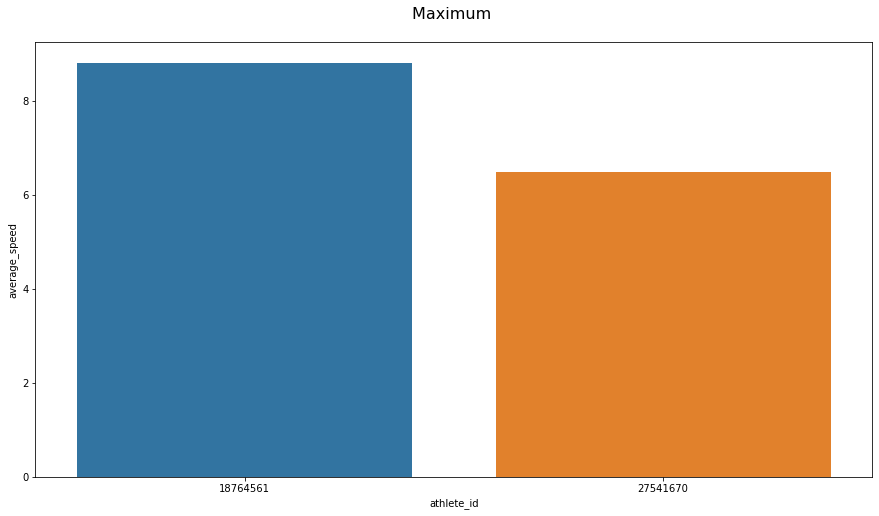

In [22]:
filtered=df_flat[df_flat['type']=='Ride']
grouped = filtered.groupby('athlete_id').agg({'average_speed':'max','max_speed':'max','distance':'max',\
                                             'total_elevation_gain':'max'}).reset_index()
grouped

import matplotlib.pyplot as plt
import seaborn as sns
 
title = 'Maximum '
 
fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(data=grouped, x='athlete_id', y='average_speed')
plt.title(title + "\n", fontsize=16)

Text(0.5, 1.0, 'Sum moving time\n')

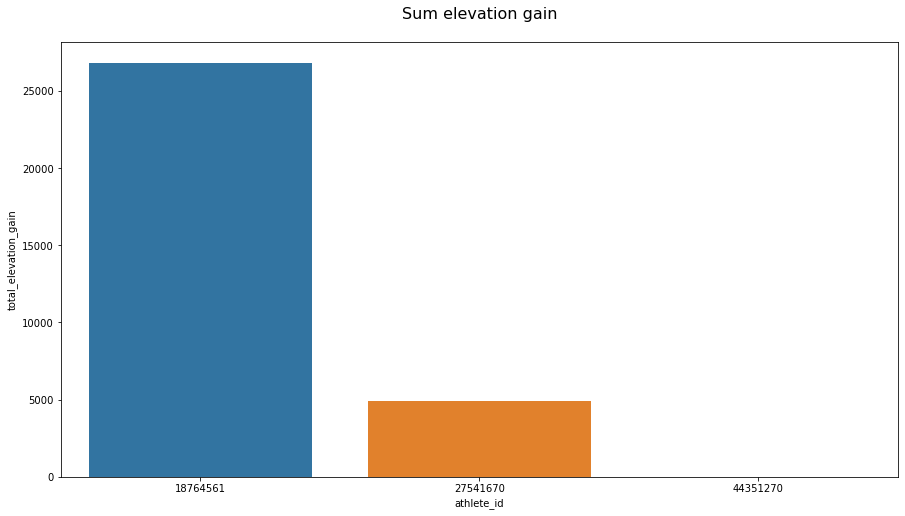

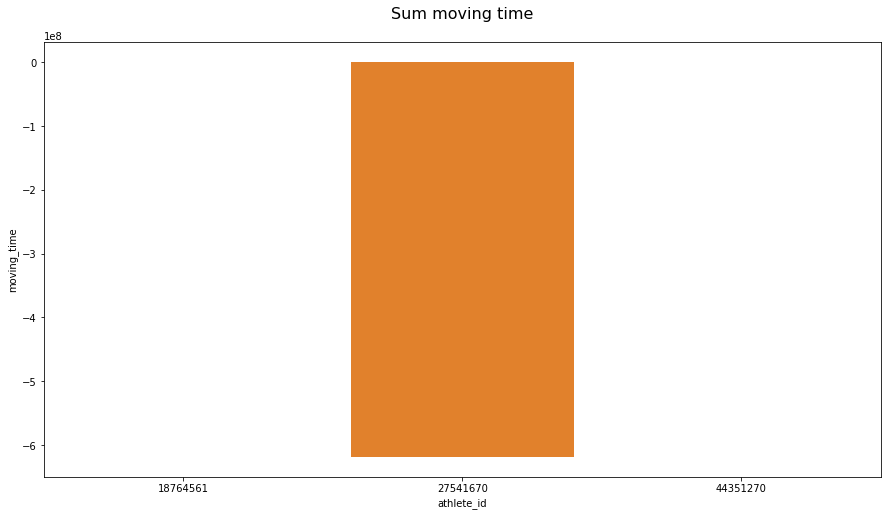

In [28]:
#filtered=df_flat[df_flat['type']=='Ride']
grouped = df_flat.groupby('athlete_id').agg({'distance':'sum',\
                                             'total_elevation_gain':'sum','moving_time':'sum'}).reset_index()
grouped

import matplotlib.pyplot as plt
import seaborn as sns
 
title = 'Sum elevation gain'
 
fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(data=grouped, x='athlete_id', y='total_elevation_gain')
plt.title(title + "\n", fontsize=16)

title = 'Sum moving time'
 
fig, ax = plt.subplots(figsize=(15,8))
barchart = sns.barplot(data=grouped, x='athlete_id', y='moving_time')
plt.title(title + "\n", fontsize=16)

### This part is not working. Strava scrapping the webpage

In [31]:
import http.cookiejar as cookielib
import time
import urllib
#import urllib2
from bs4 import BeautifulSoup


#from credentials import *

TIME_BT_REQUESTS = 0.5

def log_in():
    print ("Logging in...")
    cj = cookielib.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))

    f = opener.open('https://www.strava.com/login')
    soup = BeautifulSoup(f.read())

    time.sleep(TIME_BT_REQUESTS)

    utf8 = soup.findAll('input', {'name': 'utf8'})[0].get('value').encode('utf-8')
    token = soup.findAll('input', {'name': 'authenticity_token'})[0].get('value')
    
    

    values = {
        'utf8': utf8,
        'authenticity_token': token,
        'email': 'cglllcglll@gmail.com',
        'password': 'Holamundo9.',
    }

    data = urllib.parse.urlencode(values)
    print(data)
    url = 'https://www.strava.com/session'
    
    response = opener.open(url, data)
    soup = BeautifulSoup(response.read())
    print(soup)
    time.sleep(TIME_BT_REQUESTS)
    return opener

def get_athlete_info(opener, athlete_id):
    # without these headers, the request doesn't return anything
    opener.addheaders = [
        ('X-Requested-With', 'XMLHttpRequest'),
        ('Accept', 
            ('text/javascript, application/javascript, application/ecmascript,'
            ' application/x-ecmascript')
        ),
    ]

    url = 'http://www.strava.com/athletes/%s/profile_sidebar_comparison' \
            % athlete_id
    try:
        response = opener.open(url)
    except e:
        print ('%s - %s' % (e, athlete_id))
        return {'error': 'fail5'}

    if response.getcode() != 200:
        raise Exception('Athlete info: %s - %s' % \
                (response.getcode(), response.msg))

    soup = BeautifulSoup(response.read())
    time.sleep(TIME_BT_REQUESTS)

    # find the data we're interested in
    run_info = list(soup.childGenerator())[4]

    # first get the 10k record
    try:
        records = list(run_info.childGenerator())[7]
        records = list(records.childGenerator())[3]
    except:
        return {'error': 'fail1'}

    ten_k = None
    for item in records.childGenerator():
        if '10k' in str(item):
            record = list(item.childGenerator())[3]
            record = record.text 

            # time is in the format 1:02:23 or 45:54
            # convert it to seconds
            splitted = record.split(':')
            try:
                seconds = int(splitted[-1]) + int(splitted[-2]) * 60
            except:
                return {'error': 'fail4'}
            if len(splitted) == 3:
                seconds += int(splitted[0]) * 3600
            ten_k = seconds
            break

    if not ten_k:
        return {'error': 'fail2'}

    # then see if the user was active all year (don't want
    # to include people that just started using strava, since they may
    # have training outsite of strava that would mess the results)
    this_year = list(run_info.childGenerator())[9]
    this_year = list(this_year.childGenerator())[3]
    this_year = list(this_year.childGenerator())[1]
    this_year = list(this_year.childGenerator())[3].text

    all_time = list(run_info.childGenerator())[11]
    all_time = list(all_time.childGenerator())[3]
    all_time = list(all_time.childGenerator())[1]
    all_time = list(all_time.childGenerator())[3].text

    if this_year == all_time:
        return {'error': 'fail3'}

    if 'km' not in this_year:
        raise Exception('weird')
    this_year = float(this_year[:-2].replace(',',''))

    return {
        '10k': ten_k,
        'year': this_year
    }

In [32]:
import time

import requests
import simplejson as json

TIME_BT_REQUESTS = 0.5

def get_athletes():
	# taking athletes from http://www.strava.com/challenges/turn-up-the-heat-run
	# there are 17311 athletes registered for that challenge
	total_pages = int(173 / 50)

	athletes = []
	for page in range(1, total_pages + 2):
		url = ('http://www.strava.com/challenges/192/details?paging_type='
				'overall&per_page=50&overall_page=%s&overall_male_page=1'
				'&overall_female_page=1&_=1384604957879') % page

		r = requests.get(url)
		data = json.loads(r.text)
		athletes.extend(data['athletes'].values())

		print (len(athletes))
		time.sleep(TIME_BT_REQUESTS)

In [33]:
	athletes = get_athletes()
	opener = log_in()

50
100
150
200
Logging in...
utf8=%E2%9C%93&authenticity_token=pissmKUj9r1N%2F43q2FmhxUrC%2BnP2lFMDNvU9rYXR2Cd1n2MrYNINKA7zRfcbN2pO7%2FYIcCrZw10LnRIsjxAkqw%3D%3D&email=cglllcglll%40gmail.com&password=Holamundo9.


TypeError: POST data should be bytes, an iterable of bytes, or a file object. It cannot be of type str.

In [29]:
	athletes = get_athletes()
	opener = log_in()

	athlete_data = {}

	count_valid = 0
	count_invalid = 0
	total = 0

	for athlete in athletes:
		info = get_athlete_info(opener, athlete['id'])
		athlete_data[athlete['id']] = info

#		if 'error' in info:
#			count_invalid += 1
#		else:
#			count_valid += 1

#		total += 1
#		if total % 50 == 0:
#			print ('%s %s %s' % (total, count_valid, count_invalid))

	athlete_data = [
			(key, item['10k'], item['year']) 
			for key, item in athlete_data.iteritems()
			if '10k' in item
	]

50
100
150
200
Logging in...


TypeError: POST data should be bytes, an iterable of bytes, or a file object. It cannot be of type str.

In [40]:
from bs4 import BeautifulSoup
import requests


VERSION = '0.1.0'


class StravaScraper(object):
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent
    USER_AGENT = "stravalib-scraper/%s" % VERSION

    HEADERS = {'User-Agent': USER_AGENT}

    BASE_URL = "https://www.strava.com"

    URL_LOGIN = "%s/login" % BASE_URL
    URL_SESSION = "%s/session" % BASE_URL
    URL_DASHBOARD = "%s/dashboard" % BASE_URL

    is_authed = False

    # The content from the /dashboard request post-login (if you'd like to
    # reference it at some point)
    dashboard_content = None

    def __init__(self, email, password):
        self.email = email
        self.password = password
        self.session = requests.Session()

    def get_page(self, url):
        response = self.session.get(url, headers=StravaScraper.HEADERS)
        response.raise_for_status()
        return response

    def login(self):
        response = self.get_page(StravaScraper.URL_LOGIN)
        soup = BeautifulSoup(response.content, 'html.parser')
        utf8 = soup.find_all('input',
                             {'name': 'utf8'})[0].get('value').encode('utf-8')
        token = soup.find_all('input',
                              {'name': 'authenticity_token'})[0].get('value')
        data = {
            'utf8': utf8,
            'authenticity_token': token,
            'plan': "",
            'email': self.email,
            'password': self.password,
        }
        response = self.session.post(StravaScraper.URL_SESSION,
                                     data=data,
                                     headers=StravaScraper.HEADERS)
        response.raise_for_status()
        # Simulate that redirect here:
        response = self.get_page(StravaScraper.URL_DASHBOARD)
        print(response)
        #assert("<h2>Activity Feed</h2>" in response.content)
        self.is_authed = True
        # Save this in case someone wants it later...
        self.dashboard_content = response.content

def main():
    import sys

    if len(sys.argv) < 3:
        print (sys.stderr, "Usage: ./scraper.py \"cglllcglll@gmail.com\" \"Holamundo9.\" [url=\"https://www.strava.com/login\"]")
        sys.exit(1)
    email, password = sys.argv[1:3]
    scraper = StravaScraper(email, password)
    scraper.login()
    if len(sys.argv) < 4:
        # No custom URL to hit, just print the dashboard HTML
        print (scraper.dashboard_content)
        return
    # You can pass a custom URL to hit, such as:
    # "https://www.strava.com/challenges/rapha-rising-circle-of-death"
    url = sys.argv[3]
    response = scraper.get_page(url)
    print (response.content)


if __name__ == '__main__':
    main()

<Response [200]>
b'<!-- Application Layout -->\n<!DOCTYPE html>\n<html class=\'logged-out fullscreen responsive swimming-background-1 feed3p0 old-login\' dir=\'ltr\' lang=\'en-US\' xmlns:fb=\'http://www.facebook.com/2008/fbml\' xmlns:og=\'http://opengraphprotocol.org/schema/\' xmlns=\'http://www.w3.org/TR/html5\'>\n<!--\nlayout application\n-->\n<head>\n<meta charset=\'UTF-8\'>\n<meta content=\'width = device-width, initial-scale = 1, maximum-scale = 1\' name=\'viewport\'>\n<style type=\'text/css\'>\n.spinner, .spinner .status {\n  position: relative;\n}\n.spinner {\n  margin-top: 1em;\n  margin-bottom: 1em;\n}\n.spinner .status {\n  top: 2px;\n  margin-left: 0.5em;\n}\n.spinner .status:empty {\n  display: none;\n}\n.spinner.lg .graphic {\n  border-width: 3px;\n  height: 32px;\n  width: 32px;\n}\n.spinner.tiny {\n  height: 10px;\n  width: 10px;\n}\n.spinner.centered, .spinner.vcentered {\n  box-sizing: border-box;\n  width: 100%;\n}\n.spinner.vcentered {\n  left: 0;\n  margin-top: -12p

## References API
#### 1.-http://developers.strava.com/docs/reference/
#### 2.-https://github.com/fpolignano/
#### 3.-https://github.com/Tafkas/strava-postman-collection.git
#### 4.-https://github.com/hozn/stravalib

## References scrapper
#### https://github.com/terrettaz/strava-tools
#### https://github.com/loisaidasam/stravalib-scraper
#### https://github.com/andreiolariu/data-mining-strava/blob/master/get_athlete_info.py